In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [2]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force = False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        print('%s already present -  Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
        'Expected %d folders, one per class. Found %d instead.' % (
            num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folder = maybe_extract('notMNIST_large.tar.gz')
test_folder = maybe_extract('notMNIST_small.tar.gz')
            

notMNIST_large already present -  Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present -  Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.'

def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 ==0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force = False):
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print ('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify '+ dest_filename + '. can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz',247336696)
test_filename = maybe_download('notMNIST_small.tar.gz',8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [4]:
folder_index= 1
image_index = 0

image_sample = os.listdir(train_folder[folder_index])[image_index]
image_path = os.path.join(train_folder[folder_index], image_sample)
Image(image_path)

In [5]:
image_size = 28
pixel_depth = 255.0

def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape = (len(image_files), image_size, image_size), dtype = np.float32)
    
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth/2)/pixel_depth
            if image_data.shape !=(image_size, image_size):
                raise Exception('Unexpected image shape %s' % str(image_data.shape))
            dataset[num_images,:,:] = image_data
            num_images = num_images+1
        except IOError as e:
            print('Could not read ', image_file, ':', e, 'It\'s ok. Skipping')
    
    dataset = dataset[0:num_images,:,:]
    if num_images < min_num_images:
        raise Exception('Fewer images than required %d < %d' % (num_images, min_num_images))
        
    print('Full dataset sensor', dataset.shape)
    print('Mean: ', np.mean(dataset))
    print('Std: ',np.std(dataset) )
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, force = False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder +'.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - skipping pickling' % set_filename)
        else:
            print('Pickling %s ' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename,'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to file ', set_filename, ':', e)
    return dataset_names

train_datasets = maybe_pickle(train_folder, 45000)
test_datasets = maybe_pickle(test_folder, 1800)

notMNIST_large\A.pickle already present - skipping pickling
notMNIST_large\B.pickle already present - skipping pickling
notMNIST_large\C.pickle already present - skipping pickling
notMNIST_large\D.pickle already present - skipping pickling
notMNIST_large\E.pickle already present - skipping pickling
notMNIST_large\F.pickle already present - skipping pickling
notMNIST_large\G.pickle already present - skipping pickling
notMNIST_large\H.pickle already present - skipping pickling
notMNIST_large\I.pickle already present - skipping pickling
notMNIST_large\J.pickle already present - skipping pickling
notMNIST_small\A.pickle already present - skipping pickling
notMNIST_small\B.pickle already present - skipping pickling
notMNIST_small\C.pickle already present - skipping pickling
notMNIST_small\D.pickle already present - skipping pickling
notMNIST_small\E.pickle already present - skipping pickling
notMNIST_small\F.pickle already present - skipping pickling
notMNIST_small\G.pickle already present 

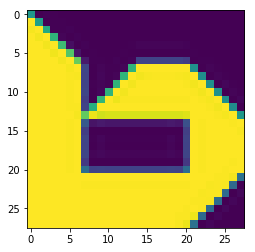

In [6]:
filename = train_folder[folder_index]
image = os.listdir(filename)[image_index]
image_file  =os.path.join(filename, image)

image_data = (ndimage.imread(image_file))
plt.imshow(image_data)

In [7]:
size_class = []
for folder in train_folder:
    images = os.listdir(folder)
    size_class.append(len(images))

print(size_class)

[52912, 52912, 52912, 52912, 52912, 52912, 52912, 52912, 52912, 52911]


In [10]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype = np.float32)
        labels = np.ndarray(nb_rows, dtype = np.float32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size = 0):
    num_classes  = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0,0 
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class + tsize_per_class
    
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file,'rb') as f:
                letter_set = pickle.load(f)
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class,:,:]
                    valid_dataset[start_v:end_v,:,:] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v +=vsize_per_class
                    end_v += vsize_per_class
            
                train_letter = letter_set[vsize_per_class:end_l,:,:]
                train_dataset[start_t:end_t,:,:] = train_letter
                train_labels[start_t:end_t] = label
                start_t +=tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from ', pickle_file,':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training: ', train_dataset.shape, train_labels.shape)
print('Validating: ', valid_dataset.shape, valid_labels.shape)
print('Testing: ', test_dataset.shape, test_labels.shape)



Training:  (200000, 28, 28) (200000,)
Validating:  (10000, 28, 28) (10000,)
Testing:  (10000, 28, 28) (10000,)


In [11]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset_shuffle, train_labels_shuffle = randomize(train_dataset, train_labels)
valid_dataset_shuffle, valid_labels_shuffle = randomize(valid_dataset, valid_labels)
test_dataset_shuffle, test_labels_shuffle = randomize(test_dataset, test_labels)
    
    

In [18]:
def image_dist(image1, image2):
    return np.sum((image1 - image2)**2)

image_one = train_dataset_shuffle[0,:,:]
label_one = train_labels_shuffle[0]

for index in range(0,train_dataset.shape[0]):
    if image_dist(image_one, train_dataset[index,:,:])==0:
        if label_one == train_labels[index]:
            print('Success')
        else:
            print('Shuffle failed')
        
    

Success
